In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, statsmodels.stats.api as sms
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, scale

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from datetime import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

#import dataset of (almost) complete age data by name and class from: https://titanicfacts.net/titanic-passenger-list/
# first= pd.read_csv('age_1st.csv', sep='\t')
# second= pd.read_csv('age_2nd.csv', sep='\t')
# third= pd.read_csv('age_3rd.csv', sep='\t')

In [3]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
# train_data.set_index(train_data.PassengerId, inplace=True)
# train_data.drop(columns=['PassengerId'], inplace=True)
# test_data.set_index(test_data.PassengerId, inplace=True)
# test_data.drop(columns=['PassengerId'], inplace=True)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Data Manipulation


In [8]:
# for tarin/test
def data_manip(tt):
#     adding name length as a feature, since back at the time, usualy the longer the name more respectful is the person (less related to the economic status)
    tt['NameLength'] = tt['Name'].apply(len) 
#     split name to first_name and surname
    tt = tt.merge(tt['Name'].str.split(',', expand=True),left_index=True, right_index=True,)
    
#     tt.drop(columns=['Name','key_0'], inplace=True)
    tt = tt.rename(columns={0: 'Surname', 1: 'First_Names'})
    
#     split title from first name
    tt[['title','First_Names']] = tt['First_Names'].str.split('.', n=1, expand=True)
    
#     some cleanup
    for i in ['Surname', 'First_Names', 'title']:
        tt[i] = tt[i].map(lambda x: x.strip())
        
#     binary column to numerical binary values
    tt['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
    
#     encoding first and last names since there is some typing differences between the given data and the internet data
    tt['consonant_sur'] = tt.Surname.str.replace('\W','').str.lower().str.replace(r'[aeiou]','')
    tt['consonant_fn'] = tt.First_Names.str.replace('\W','').str.lower().str.replace('[aeiou]','').map(lambda x: str(x)[0:5])
    
#     making cabin a boolean value
    tt['Cabin'] = ~tt.Cabin.isna()

    return tt.drop(columns=['Name'])

In [9]:
train_data = data_manip(train_data)
test_data = data_manip(test_data)

In [10]:
train_data[train_data.Age.isna()].head()

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Ticket     Fare  \
5             6         0       3    0  NaN      0      0  330877   8.4583   
17           18         1       2    0  NaN      0      0  244373  13.0000   
19           20         1       3    1  NaN      0      0    2649   7.2250   
26           27         0       3    0  NaN      0      0    2631   7.2250   
28           29         1       3    1  NaN      0      0  330959   7.8792   

    Cabin Embarked  NameLength     Surname     First_Names title  \
5   False        Q          16       Moran           James    Mr   
17  False        S          28    Williams  Charles Eugene    Mr   
19  False        C          23  Masselmani          Fatima   Mrs   
26  False        C          23        Emir   Farred Chehab    Mr   
28  False        Q          29     O'Dwyer  Ellen "Nellie"  Miss   

   consonant_sur consonant_fn  
5            mrn          jms  
17         wllms        chrls  
19        msslmn          ftm  
26            mr        frrdc  
28          dwyr        llnnl

In [11]:
# for age table
def age_cleaning(df):
#     remove leading and trailing spaces
    for i, c in enumerate(df.columns):
        df = df.rename(columns={c: df.columns.str.strip()[i]})
#     align same columns naming as in train/test
    df=df.rename(columns={'Survivor (S) or Victim (†)': 'Survived', 'Boarded': 'Embarked', 'First Names': 'First_Names'})
#     remove leading and trailing spaces
    for c in list(df.dtypes.index):
        if df[c].dtypes == 'object':
            df[c] = df[c].map(lambda x: x.strip())
    
    
    df['Survived'].replace({'S': 1, '†': 0}, inplace=True)
    df['Survived'].astype('int32')
    df['Embarked'] = df.Embarked.str[0]
    
#     transform age in months to years old
    for r in list(df[df.Age.str.contains('m')].index.values):
        df.at[r, 'Age'] = str(round(float(df.at[r, 'Age'].rstrip('m'))/12,2))
    
    df[['title','First_Names']] = df['First_Names'].str.split(' ', n=1, expand=True)
#     some cleanup
    for i in ['Surname', 'First_Names', 'title']:
        df[i] = df[i].map(lambda x: x.strip())
#     encoding first and last names since there is some typing differences between the given data and the internet data
    df['consonant_sur'] = df.Surname.str.replace('\W','').str.lower().str.replace(r'[aeiou]','')
    df['consonant_fn'] = df.First_Names.str.replace('\W','').str.lower().str.replace('[aeiou]','').map(lambda x: str(x)[0:5])
  
    return df

In [12]:
# unify age classes to one dataframe
# first = age_cleaning(first)
# second = age_cleaning(second)
# third = age_cleaning(third)
# first['Pclass']=1
# second['Pclass']=2
# third['Pclass']=3
# age = pd.concat([first,second,third])
# age.reset_index(drop=True, inplace=True)
# del([first, second, third])

In [13]:
# age.columns
# age.head()

In [14]:
# age.describe()
# where is the Age column?

In [15]:
# age.describe(include='O')
# [i for i in age.Age if i.isalpha()]

In [16]:
# no age records around the net, so i'll just drop them from the analysis
# age[age.Age=='NK']
# age.drop(age[age.Age=='NK'].index, inplace=True)
# age = age.astype({'Age': 'float32'})

In [17]:
train_data[train_data.Embarked.isna()]

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Ticket  Fare  \
61            62         1       1    1  38.0      0      0  113572  80.0   
829          830         1       1    1  62.0      0      0  113572  80.0   

     Cabin Embarked  NameLength Surname                    First_Names title  \
61    True      NaN          19   Icard                         Amelie  Miss   
829   True      NaN          41   Stone  George Nelson (Martha Evelyn)   Mrs   

    consonant_sur consonant_fn  
61            crd           ml  
829           stn        grgnl

In [18]:
# find the 2 missing Embarked values
# for i in train_data[train_data.Embarked.isna()].index:
#     train_data.at[i,'Embarked'] = age[age.consonant_sur==train_data.at[i,'consonant_sur']]['Embarked'].values[0]
# train_data.iloc[[61]]
# train_data.iloc[[829]]

In [19]:
train_data[train_data.Age.isna()]
train_data.shape

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch      Ticket  \
5              6         0       3    0  NaN      0      0      330877   
17            18         1       2    0  NaN      0      0      244373   
19            20         1       3    1  NaN      0      0        2649   
26            27         0       3    0  NaN      0      0        2631   
28            29         1       3    1  NaN      0      0      330959   
..           ...       ...     ...  ...  ...    ...    ...         ...   
859          860         0       3    0  NaN      0      0        2629   
863          864         0       3    1  NaN      8      2    CA. 2343   
868          869         0       3    0  NaN      0      0      345777   
878          879         0       3    0  NaN      0      0      349217   
888          889         0       3    1  NaN      1      2  W./C. 6607   

        Fare  Cabin Embarked  NameLength        Surname  \
5     8.4583  False        Q          16          Moran   
17   13.0000  False        S          28       Williams   
19    7.2250  False        C          23     Masselmani   
26    7.2250  False        C          23           Emir   
28    7.8792  False        Q          29        O'Dwyer   
..       ...    ...      ...         ...            ...   
859   7.2292  False        C          16           Razi   
863  69.5500  False        S          33           Sage   
868   9.5000  False        S          27  van Melkebeke   
878   7.8958  False        S          18         Laleff   
888  23.4500  False        S          40       Johnston   

                  First_Names title consonant_sur consonant_fn  
5                       James    Mr           mrn          jms  
17             Charles Eugene    Mr         wllms        chrls  
19                     Fatima   Mrs        msslmn          ftm  
26              Farred Chehab    Mr            mr        frrdc  
28             Ellen "Nellie"  Miss          dwyr        llnnl  
..                        ...   ...           ...          ...  
859                    Raihed    Mr            rz          rhd  
863     Dorothy Edith "Dolly"  Miss            sg        drthy  
868                  Philemon    Mr       vnmlkbk        phlmn  
878                    Kristo    Mr          llff         krst  
888  Catherine Helen "Carrie"  Miss        jhnstn        cthrn  

[177 rows x 17 columns]

(891, 17)

In [20]:
# def age_from_net(df, age):
#     tt = pd.merge(df, 
#          age[['Pclass', 'Embarked','consonant_sur', 'consonant_fn', 'title', 'Age']], 
#          how='left', 
#          on=['Pclass', 'Embarked','consonant_sur', 'consonant_fn', 'title'])
#     tt['check'] = ~tt.Age_x.isna()
#     tt['Age'] = tt.apply(lambda x: x.Age_x if x.check else x.Age_y, axis=1)
    
#     return tt.drop(columns=['check', 'Age_y', 'Age_x'])

In [21]:
# train rows without a clear age
# train_data =  age_from_net(train_data, age)

# test rows without a clear age
# test_data = age_from_net(test_data, age)


In [22]:
print(f'there are {len(train_data[train_data.Age.isna()])} rows without a clear age in the train set')
print(f'there are {len(test_data[test_data.Age.isna()])} rows without a clear age in the test set')

there are 177 rows without a clear age in the train set
there are 86 rows without a clear age in the test set


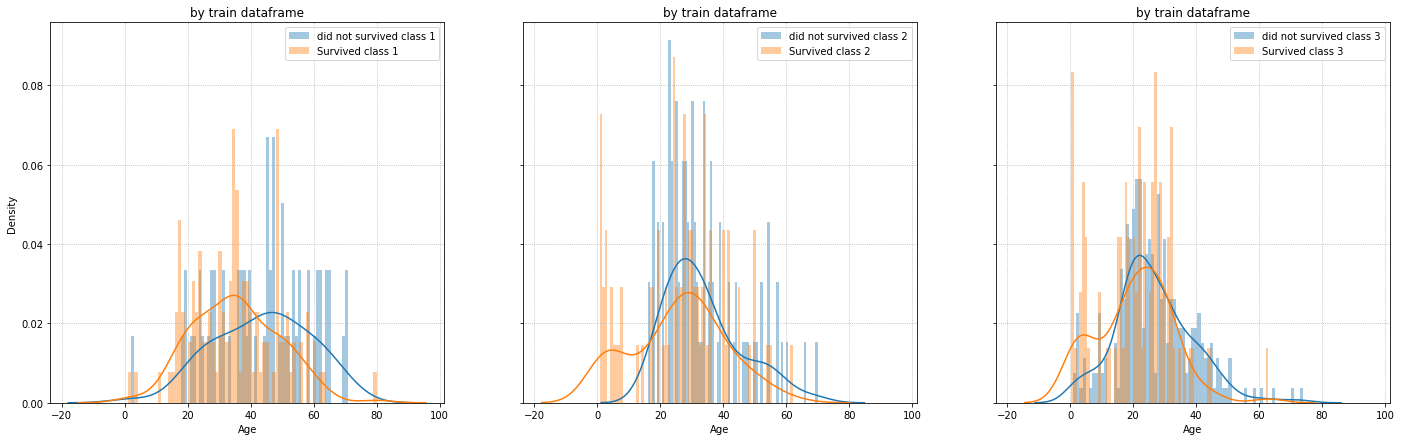

In [23]:
f, axes = plt.subplots(1,3, figsize=(24,7), sharex=True, sharey=True)
for j in range(2):
    for i in range(3):
        if j == 0:
            b=sns.distplot(train_data[train_data['Survived']==j][train_data.Pclass==i+1].Age.astype('float32'), 
                         label='did not survived class {}'.format(i+1),
                         bins=74,
                         ax=axes[i],
                         norm_hist=True).set_title('by train dataframe')
        else:
            b=sns.distplot(train_data[train_data['Survived']==j][train_data.Pclass==i+1].Age.astype('float32'), 
                         label='Survived class {}'.format(i+1),
                         bins=74,
                         ax=axes[i],
                         norm_hist=True).set_title('by train dataframe')
        c=axes[i].legend()
        
        grid = axes[i].grid(ls=':')

In [24]:
train_data['Parch'] = train_data.apply(lambda x: True if x.Parch else False, axis=1)
train_data['SibSp'] = train_data.apply(lambda x: True if x.SibSp else False, axis=1)

In [25]:
len(set(train_data.Surname))

667

In [26]:
train_data.shape
train_data.columns

(891, 17)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLength', 'Surname',
       'First_Names', 'title', 'consonant_sur', 'consonant_fn'],
      dtype='object')

In [27]:
corr_mat = train_data.drop(columns=['PassengerId']).corr()
corr_mat

Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived    1.000000 -0.338481  0.543351 -0.077221  0.115867  0.147408   
Pclass     -0.338481  1.000000 -0.131900 -0.369226 -0.076009 -0.027526   
Sex         0.543351 -0.131900  1.000000 -0.093254  0.203203  0.247523   
Age        -0.077221 -0.369226 -0.093254  1.000000 -0.162893 -0.280626   
SibSp       0.115867 -0.076009  0.203203 -0.162893  1.000000  0.420233   
Parch       0.147408 -0.027526  0.247523 -0.280626  0.420233  1.000000   
Fare        0.257307 -0.549500  0.182333  0.096067  0.192190  0.237717   
Cabin       0.316912 -0.725541  0.140391  0.249732  0.075769  0.089136   
NameLength  0.332350 -0.220001  0.448759  0.034612  0.349501  0.245209   

                Fare     Cabin  NameLength  
Survived    0.257307  0.316912    0.332350  
Pclass     -0.549500 -0.725541   -0.220001  
Sex         0.182333  0.140391    0.448759  
Age         0.096067  0.249732    0.034612  
SibSp       0.192190  0.075769    0.349501  
Parch       0.237717  0.089136    0.245209  
Fare        1.000000  0.482075    0.155832  
Cabin       0.482075  1.000000    0.190943  
NameLength  0.155832  0.190943    1.000000

(0, 9)

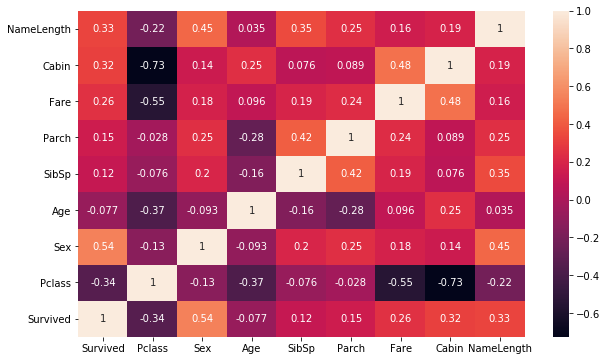

In [28]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(corr_mat, annot=True)
plt.ylim(0,len(corr_mat))

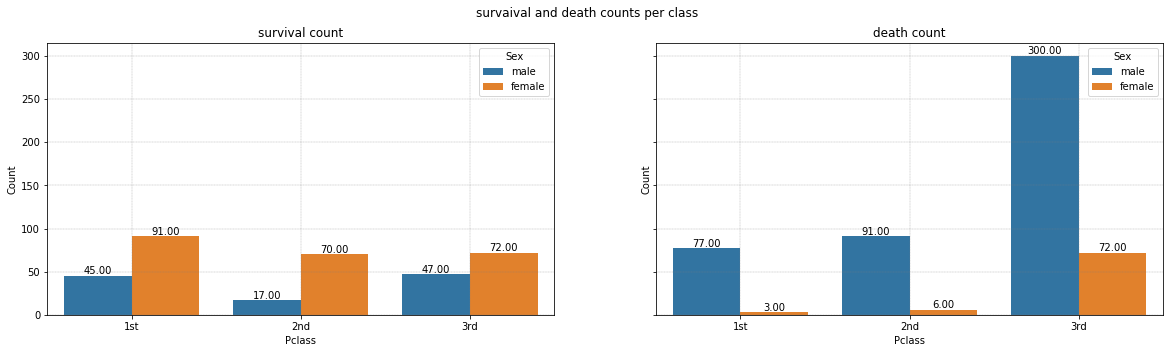

In [29]:
prop_surv = pd.DataFrame(train_data['Sex'][train_data['Survived']==1]
                         .groupby(train_data['Pclass']).value_counts(sort=False))
prop_surv.rename(columns={'Sex': 'Count'}, inplace=True)
prop_surv.reset_index(inplace=True)
prop_surv['Sex'].replace({0: 'male', 1: 'female'},inplace=True)

prop_not_surv = pd.DataFrame(train_data['Sex'][train_data['Survived']==0]
                             .groupby(train_data['Pclass']).value_counts(sort=False))
prop_not_surv.rename(columns={'Sex': 'Count'}, inplace=True)
prop_not_surv.reset_index(inplace=True)
prop_not_surv['Sex'].replace({0: 'male', 1: 'female'},inplace=True)

f, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)

survival = sns.barplot(data=prop_surv, x='Pclass', y='Count', hue='Sex', ax=axes[0]).set_title('survival count')
ticks0 = axes[0].set_xticklabels(['1st','2nd','3rd'])
axes[0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

death = sns.barplot(data=prop_not_surv, x='Pclass', y='Count', hue='Sex', ax=axes[1]).set_title('death count')
ticks1 = axes[1].set_xticklabels(['1st','2nd','3rd'])
axes[1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
st = plt.suptitle('survaival and death counts per class')    


for i in range(2):
    for j, p in enumerate(axes[i].patches):
        h = p.get_height()
        fm = axes[i].text(p.get_x()+p.get_width()/2., 
                     h+2, 
                     '{:.2f}'.format(h),
                     ha='center')
plt.show()

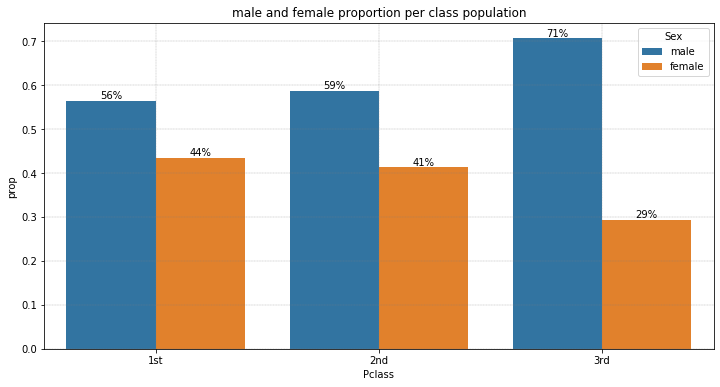

In [30]:
gender = pd.DataFrame(train_data['Sex'].groupby(train_data['Pclass']).value_counts(normalize=True))
gender.rename(columns={'Sex': 'prop'}, inplace=True)
gender.reset_index(inplace=True)
gender['Sex'].replace({0: 'male', 1: 'female'},inplace=True)

fsize = plt.figure(figsize=(12,6))
ax = sns.barplot(data=gender, x='Pclass', y='prop', hue='Sex')
title = plt.title('male and female proportion per class population')
ticks = ax.set_xticklabels(['1st', '2nd', '3rd'])
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

for p in ax.patches:
        h = p.get_height()
        fm = ax.text(p.get_x()+p.get_width()/2., 
                     h+0.005, 
                     '{:.0%}'.format(h),
                     ha='center')

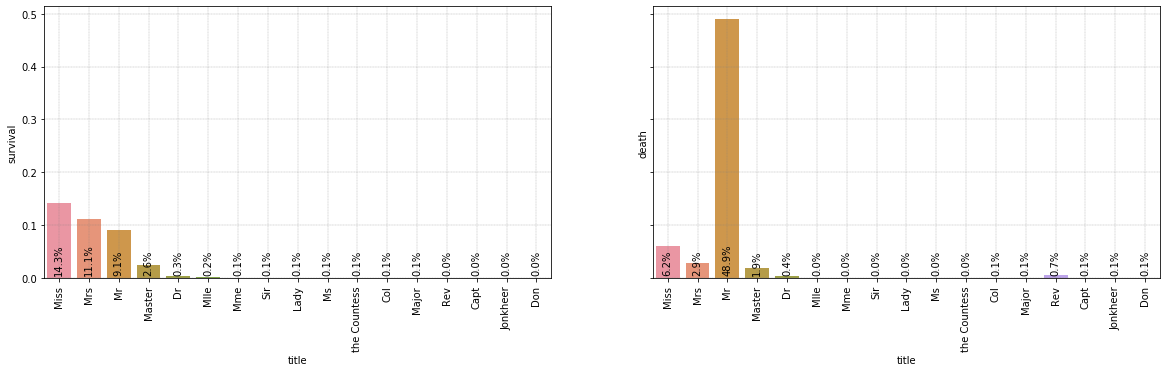

In [31]:
t_surv = pd.DataFrame(train_data['title'][train_data['Survived']==1].value_counts(sort=True)).rename(columns={'title': 'survived'})
t_n_surv = pd.DataFrame(train_data['title'][train_data['Survived']==0].value_counts(sort=True)).rename(columns={'title': 'did_not_survive'})
t_tot = pd.DataFrame(train_data['title'].value_counts(sort=True)).rename(columns={'title': 'total'})

title = pd.concat([t_surv, t_n_surv, t_tot], axis=1).fillna(0).reset_index()
title.rename(columns={'index': 'title'}, inplace=True)
title['death'] = title['did_not_survive']/sum(title['total'])
title['survival'] = title['survived']/sum(title['total'])

f , axes = plt.subplots(1,2, figsize=(20,5), sharey=True)
a=sns.barplot(data=title, x='title', y='survival', ax=axes[0]).set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

b=sns.barplot(data=title, x='title', y='death',ax=axes[1]).set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

for i in range(2):
        for j, p in enumerate(axes[i].patches):
            h = p.get_height()
            fm = axes[i].text(p.get_x()+p.get_width()/2., 
                         0.01, 
                         '{:.1%}'.format(h),
                         ha='center',rotation=90)

In [32]:
# age[age.title == 'Dr']
train_data[train_data.title == 'Dr'][train_data.Surname=='Leader']

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch Ticket     Fare  \
796          797         1       1    1  49.0  False  False  17465  25.9292   

     Cabin Embarked  NameLength Surname      First_Names title consonant_sur  \
796   True        S          27  Leader  Alice (Farnham)    Dr           ldr   

    consonant_fn  
796        lcfrn

In [33]:
# keys = list((set(train_data.title.unique()) | set(test_data.title.unique()) | set(age.title.unique())) - set(['Miss', 'Mrs', 'Mr', 'Master', 'Dr']))
keys = list((set(train_data.title.unique()) | set(test_data.title.unique())) - set(['Miss', 'Mrs', 'Mr', 'Master', 'Dr']))
keys.sort()
values = ['Mr', 
          'Mr', 
          'Mr', 
          'Mr', 
          'Mr', 
          'Mr', 
          'Mrs', 
          'Mrs', 
          'Mr', 
          'Master', 
          'Mrs', 
          'Miss', 
          'Mr', 
          'Miss', 
          'Mrs', 
          'Mrs', 
          'Mr', 
          'Miss', 
          'Mr', 
          'Mr', 
          'Mr', 
          'Mr',
          'Mr', 
          'Mrs']
title_dict = dict(zip(keys, values))
title_dict

{'Capt': 'Mr',
 'Col': 'Mr',
 'Don': 'Mr',
 'Dona': 'Mr',
 'Jonkheer': 'Mr',
 'Lady': 'Mr',
 'Major': 'Mrs',
 'Mlle': 'Mrs',
 'Mme': 'Mr',
 'Ms': 'Master',
 'Rev': 'Mrs',
 'Sir': 'Miss',
 'the Countess': 'Mr'}

In [34]:
def Title(tt):
    if 'Sex' in tt.columns:
        tt['title'] = tt.apply(lambda x: 'Mrs' if x.title=='Dr' and x.Sex==1 else x.title, axis=1)
    tt.title.replace(to_replace=title_dict, inplace=True)
    for dr in list(tt[tt.title=='Dr'].index):
        tt.title.replace(to_replace={'Dr': 'Mr'}, inplace=True)
    return tt

In [35]:
train_data['title'] = train_data.apply(lambda x: 'Mrs' if x.title=='Dr' and x.Sex==1 else x.title, axis=1)
train_data[train_data.title=='Dr']

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch    Ticket    Fare  \
245          246         0       1    0  44.0   True  False     19928   90.00   
317          318         0       2    0  54.0  False  False     29011   14.00   
398          399         0       2    0  23.0  False  False    244278   10.50   
632          633         1       1    0  32.0  False  False     13214   30.50   
660          661         1       1    0  50.0   True  False  PC 17611  133.65   
766          767         0       1    0   NaN  False  False    112379   39.60   

     Cabin Embarked  NameLength           Surname     First_Names title  \
245   True        Q          27           Minahan  William Edward    Dr   
317  False        S          20          Moraweck          Ernest    Dr   
398  False        S          16              Pain          Alfred    Dr   
632   True        C          25  Stahelin-Maeglin             Max    Dr   
660  False        S          29        Frauenthal   Henry William    Dr   
766  False        C          25             Brewe  Arthur Jackson    Dr   

    consonant_sur consonant_fn  
245          mnhn        wllmd  
317         mrwck         rnst  
398            pn         lfrd  
632     sthlnmgln           mx  
660        frnthl        hnryw  
766           brw        rthrj

In [36]:
train_data = Title(train_data)
test_data = Title(test_data)
# age = Title(age)

In [37]:
for i in set(list(train_data.columns))-set(list(test_data.columns)):
    test_data[i]=0
       
test_data.drop(columns=['Survived'], inplace=True)

In [38]:
for i in set(list(test_data.columns))-set(list(train_data.columns)):
    train_data[i]=0

In [39]:
age_title_class = {}
for i in range(1,4,1):
    surv = pd.DataFrame(train_data['title'][train_data['Pclass']==i].value_counts(sort=True)).rename(columns={'title': 'count'})
    age_title_class['class{}'.format(i)]=pd.concat([surv,
               pd.DataFrame(train_data[train_data['Pclass']==i][['Age','title']].dropna().groupby(['title']).mean()).rename(columns={'Age': 'Age_mean'}),
               pd.DataFrame(train_data[train_data['Pclass']==i][['Age','title']].dropna().groupby(['title']).median()).rename(columns={'Age': 'Age_median'}),
               pd.DataFrame(train_data[train_data['Pclass']==i][['Age','title']].dropna().groupby(['title']).std()).rename(columns={'Age': 'Age_std'}),
               pd.DataFrame(train_data[train_data['Pclass']==i][['Age','title']].dropna().groupby(['title']).min()).rename(columns={'Age': 'Age_min'}),
               pd.DataFrame(train_data[train_data['Pclass']==i][['Age','title']].dropna().groupby(['title']).max()).rename(columns={'Age': 'Age_max'})], 
              axis=1).dropna()

- verifing the NA Age group doesn't have unique titles

In [40]:
age_title_class['class1']
train_data[train_data.Age.isna()][train_data.Pclass==1].title.value_counts()

count   Age_mean  Age_median    Age_std  Age_min  Age_max
Mr        119  41.964286        40.0  14.055532    17.00     80.0
Mrs        47  40.615385        43.0  12.617063    17.00     62.0
Miss       47  30.413043        30.0  13.013798     2.00     63.0
Master      3   5.306667         4.0   5.165475     0.92     11.0

Mr      21
Mrs      8
Miss     1
Name: title, dtype: int64

In [41]:
age_title_class['class2']
train_data[train_data.Age.isna()][train_data.Pclass==2].title.value_counts()

count   Age_mean  Age_median    Age_std  Age_min  Age_max
Mr         93  32.904762        31.0  11.984296    16.00     70.0
Mrs        47  34.893617        33.0  11.026123    14.00     57.0
Miss       34  22.390625        24.0  13.374708     2.00     50.0
Master     10   4.833000         1.5   8.434373     0.67     28.0

Mr      9
Miss    2
Name: title, dtype: int64

In [42]:
age_title_class['class3']
train_data[train_data.Age.isna()][train_data.Pclass==3].title.value_counts()

count   Age_mean  Age_median    Age_std  Age_min  Age_max
Mr        319  28.724891        26.0  10.490946    11.00     74.0
Miss      102  16.123188        18.0   9.697315     0.75     45.0
Mrs        42  33.515152        31.0  10.031579    15.00     63.0
Master     28   5.350833         4.0   3.593608     0.42     12.0

Mr        90
Miss      33
Mrs        9
Master     4
Name: title, dtype: int64

In [43]:
# according the result above i may fill the NA with normal random value
def rand_age(df):
    for r in df[df.Age.isna()].index:
        c = df.Pclass.loc[r]
        t = df.title.loc[r]
        mu = age_title_class['class{}'.format(c)].at[t, 'Age_mean']
        sd = age_title_class['class{}'.format(c)].at[t, 'Age_std']
        df.at[r, 'Age'] = np.round(np.random.normal(loc = mu, scale = sd),1)
    return

In [44]:
rand_age(train_data)
rand_age(test_data)
train_data.title.value_counts()
test_data.title.value_counts()

Mr        531
Miss      183
Mrs       136
Master     41
Name: title, dtype: int64

Mr        244
Miss       78
Mrs        74
Master     22
Name: title, dtype: int64

In [45]:
# test data have a fare missing value
test_data[test_data.Fare.isna()]
test_data.at[152, 'Fare'] = np.mean(train_data.Fare[train_data['Sex']==0][train_data['Pclass']==3][train_data.Age>50])

PassengerId  Pclass  Sex   Age  SibSp  Parch Ticket  Fare  Cabin  \
152         1044       3    0  60.5      0      0   3701   NaN  False   

    Embarked  NameLength Surname First_Names title consonant_sur consonant_fn  
152        S          18  Storey      Thomas    Mr          stry         thms

In [46]:
train_data = train_data[~train_data.duplicated()]

In [47]:
train_data.set_index(train_data.PassengerId, inplace=True)
test_data.set_index(test_data.PassengerId, inplace=True)

In [48]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLength', 'Surname',
       'First_Names', 'title', 'consonant_sur', 'consonant_fn'],
      dtype='object')

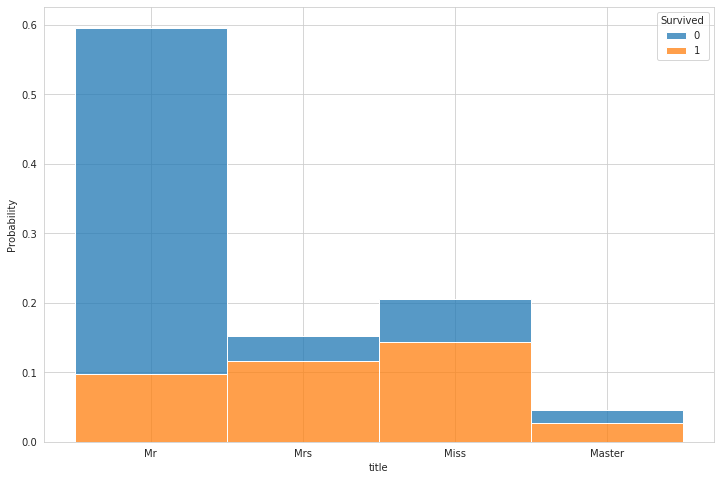

In [49]:
x = 'title'
hue = 'Survived'

sns.set_style('whitegrid')
f = plt.figure(figsize=(12,8))
ax = sns.histplot(data=train_data, 
                  x=x, 
                  hue=hue, 
                  stat='probability', 
                  multiple='stack')

In [50]:
def features_maker(df,*columns, triplets=False):
#     creating couples or triplets from columns list, with all possible combinations
#     df - stands for pandas dataframe
#     *columns - list of columns names of the dataframe
#     triplets - to create tiplets instead of couples, default False (couples)
    columns = list(columns)
    
    if triplets:
        couple = [columns.pop(0), columns.pop(0)]
        while len(columns)>0:
            for third in columns:
                df[f'{couple[0]}_{couple[1]}_{third}'] = df.apply(lambda x: f'{str(x[couple[0]])}_{str(x[couple[1]])}_{third}', axis=1)
            del couple[0]
            couple.append(columns.pop(0))
    else:
        while len(columns)>1:
            first = columns.pop()
            for second in columns:
                df[f'{first}_{second}'] = df.apply(lambda x: f'{str(x[first])}_{str(x[second])}', axis=1)
    return #df 

In [51]:
# features_maker(train_data,*['title', 'Pclass', 'Cabin'], triplets=True)
# features_maker(test_data,*['title', 'Pclass', 'Cabin'], triplets=True)

In [52]:
train_data.columns
test_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLength', 'Surname',
       'First_Names', 'title', 'consonant_sur', 'consonant_fn'],
      dtype='object')

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'NameLength', 'Surname', 'First_Names',
       'title', 'consonant_sur', 'consonant_fn'],
      dtype='object')

In [53]:
def dropper(df, *to_drop):
    drop_list = []
    for drop in to_drop:
        if drop in df.columns:
            drop_list.append(drop)
    df.drop(columns=drop_list, inplace=True)
    return #df

In [54]:
to_drop = ['consonant_sur','consonant_fn', 'Surname', 'First_Names', 'Ticket', 'PassengerId', 'Embarked', 'Age']
dropper(train_data, *to_drop)
train_data.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'NameLength', 'title'],
      dtype='object')

In [55]:
dropper(test_data, *to_drop)
test_data.columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'NameLength',
       'title'],
      dtype='object')

In [56]:
def scaler(df, *to_scale):
    scaler = MinMaxScaler()
    for s in to_scale:
        if s in df.columns:
            df[s] = scaler.fit_transform(np.array(df[s]).reshape(-1,1))
        else:
            pass
    return #df

In [57]:
to_scale = ['Age', 'Fare']
scaler(train_data, *to_scale)
scaler(test_data, *to_scale)

In [58]:
train_data.head()
train_data.columns

Survived  Pclass  Sex  SibSp  Parch      Fare  Cabin  NameLength  \
PassengerId                                                                     
1                   0       3    0   True  False  0.014151  False          23   
2                   1       1    1   True  False  0.139136   True          51   
3                   1       3    1  False  False  0.015469  False          22   
4                   1       1    1   True  False  0.103644   True          44   
5                   0       3    0  False  False  0.015713  False          24   

            title  
PassengerId        
1              Mr  
2             Mrs  
3            Miss  
4             Mrs  
5              Mr

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'NameLength', 'title'],
      dtype='object')

In [59]:
def dumbit(df, *columns):
    for col in columns:
        df = pd.get_dummies(data=df, columns=[col], prefix=[col], drop_first=True)
    return df

In [60]:
# to_dummifit = ['Cabin_title', 'Cabin_Pclass', 'Pclass_title']
to_dummifit = ['title', 'Pclass']
train_data = dumbit(train_data, *to_dummifit)
train_data.columns
test_data = dumbit(test_data, *to_dummifit)
test_data.columns

Index(['Survived', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'NameLength',
       'title_Miss', 'title_Mr', 'title_Mrs', 'Pclass_2', 'Pclass_3'],
      dtype='object')

Index(['Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'NameLength', 'title_Miss',
       'title_Mr', 'title_Mrs', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [61]:
train_data['died'] = 1-train_data.Survived

<Figure size 1800x1440 with 0 Axes>

(0, 13)

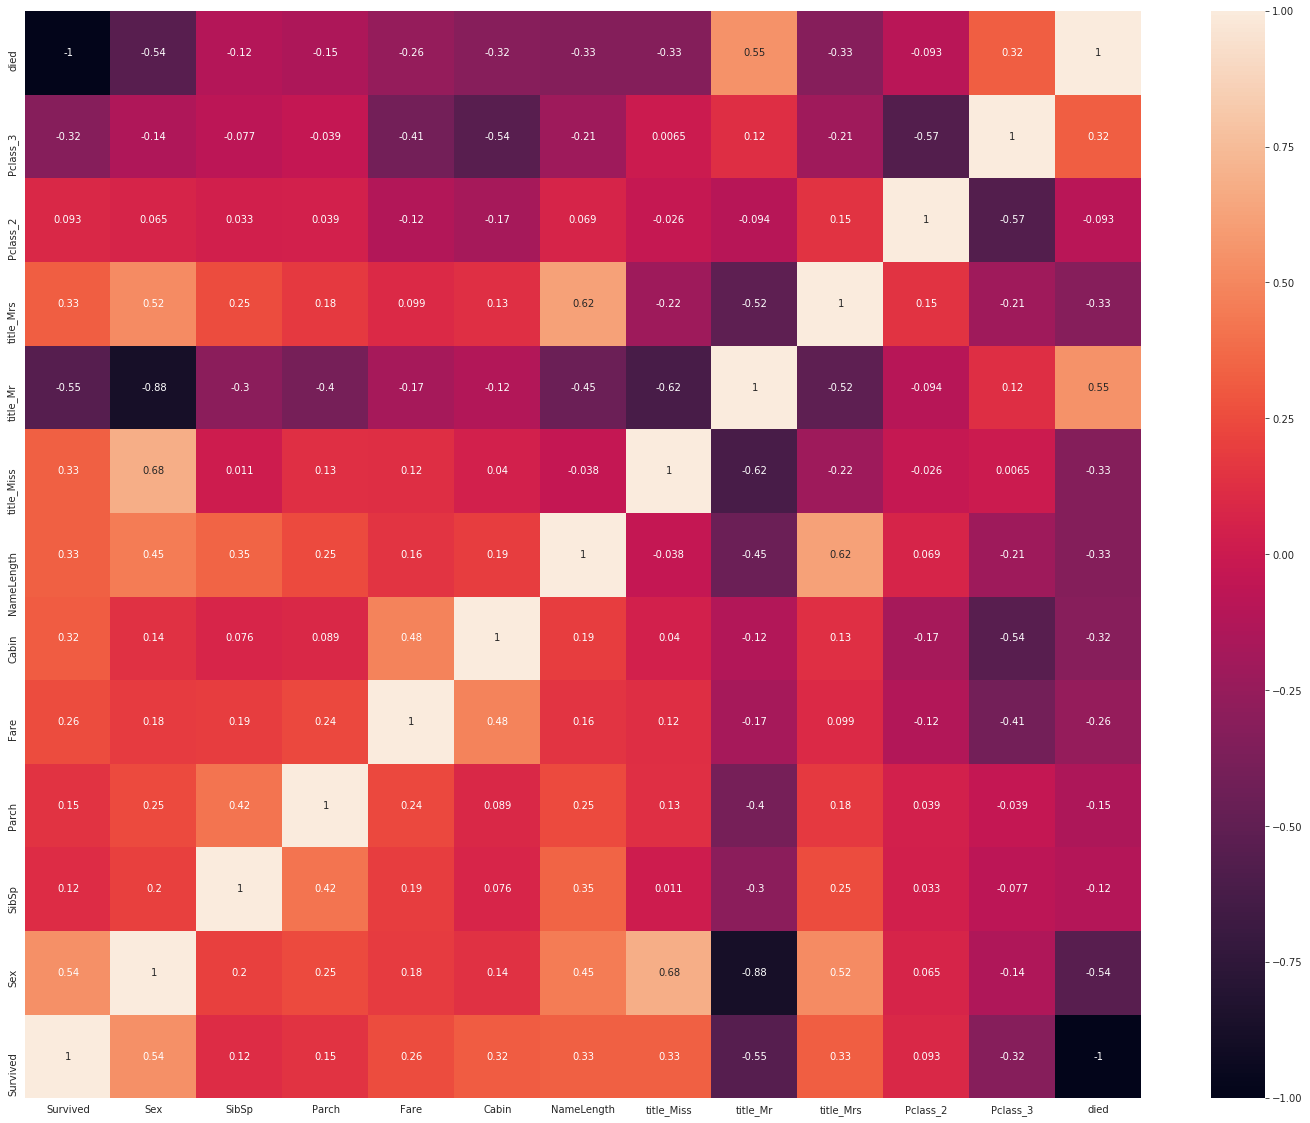

In [62]:
plt.figure(figsize=(25,20))
cormat = train_data.corr()
c = list(train_data.columns)
sns.heatmap(cormat, 
            xticklabels=c,
            yticklabels=c,
            annot=True,
            vmin=-1, vmax=1)
plt.ylim(0,len(cormat))

In [63]:
print(set(list(train_data.columns))^set(list(test_data.columns)))
       
# test_data.drop(columns=['Survived'], inplace=True)
# test_data.head()

{'died', 'Survived'}


In [64]:
# the following is a grid search function to evaluate each model in a cosen parameters and ranges
def model_score(train, model, grid_values, scorers_list):
    X_train = train.drop(columns=['Survived', 'died'])
    y_train = train['died']
    
#     clf_dict = {}
    
    for i, scorer in enumerate(scorers_list):
        clf_eval = GridSearchCV(model, param_grid=grid_values, scoring=scorer, cv=5, iid=False, n_jobs=-1)
        clf_eval.fit(X_train,y_train)
        print('Grid best parameters for {0}: {1} scoring: {2}'
              .format(scorer, clf_eval.best_params_, round(clf_eval.best_score_,3)))
#         clf_dict[scorer] = clf_eval
    return

In [65]:
data_to_train = train_data
data_to_test = test_data

### Logistic Regression

In [66]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'tol':[1e-3 , 1e-2, 1e-1, 1, 10],
        'C': [1e-4, 1e-3, 0.01, 0.1, 1],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
        'penalty': ['l2', 'none'], 
        'class_weight': [None, 'balanced']}
model_score(train=data_to_train, 
            model=LogisticRegression(n_jobs=-1, random_state=42, max_iter=1e6), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 0.0001, 'class_weight': None, 'penalty': 'none', 'solver': 'lbfgs', 'tol': 1} scoring: 0.865
Grid best parameters for accuracy: {'C': 0.0001, 'class_weight': None, 'penalty': 'none', 'solver': 'newton-cg', 'tol': 1} scoring: 0.808
Grid best parameters for precision: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga', 'tol': 0.1} scoring: 0.891
Grid best parameters for recall: {'C': 0.0001, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.1} scoring: 1.0
Grid best parameters for f1: {'C': 0.0001, 'class_weight': None, 'penalty': 'none', 'solver': 'saga', 'tol': 0.1} scoring: 0.85
CPU times: user 17.7 s, sys: 580 ms, total: 18.3 s
Wall time: 1min 31s


In [67]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'tol':[1e-1, 1e-5, 1e-3 , 1e-4, 1e-2],
        'C': [0.1, 1, 2, 5, 10],
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1'], 
        'class_weight': [None, 'balanced']}
model_score(train=data_to_train, 
            model=LogisticRegression(n_jobs=-1, random_state=42, max_iter=1e6), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-05} scoring: 0.864
Grid best parameters for accuracy: {'C': 5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001} scoring: 0.806
Grid best parameters for precision: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1} scoring: 0.882
Grid best parameters for recall: {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1} scoring: 0.982
Grid best parameters for f1: {'C': 2, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.1} scoring: 0.85
CPU times: user 4.47 s, sys: 30.4 ms, total: 4.5 s
Wall time: 1min 19s


In [68]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {
    'C': list(np.arange(0.1,0.3,0.1)),
    'solver': ['saga', ],
#     'tol': list(np.arange(0.1,1,0.1))
        }
model_score(train=data_to_train, 
            model=LogisticRegression(#C=0.01,
                                     tol=0.001, 
                                     class_weight=None,
                                     penalty='l1',
                                     n_jobs=-1, 
                                     max_iter=1e6,
                                     random_state=42), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 0.1, 'solver': 'saga'} scoring: 0.852
Grid best parameters for accuracy: {'C': 0.1, 'solver': 'saga'} scoring: 0.792
Grid best parameters for precision: {'C': 0.2, 'solver': 'saga'} scoring: 0.824
Grid best parameters for recall: {'C': 0.1, 'solver': 'saga'} scoring: 0.849
Grid best parameters for f1: {'C': 0.1, 'solver': 'saga'} scoring: 0.835
CPU times: user 268 ms, sys: 7.94 ms, total: 276 ms
Wall time: 1.23 s


In [69]:
LR_C = 0.1
LR_tol = 1e-3
LR_solver = 'saga'
LR_penalty = 'l1'
LR_class_weight = None
LR_max_iter = 1e6

### Random Forest

In [70]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'criterion':['gini', 'entropy'],
        'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
model_score(train=data_to_train, 
            model=RandomForestClassifier(n_jobs=-1, random_state=42), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'criterion': 'entropy', 'n_estimators': 100} scoring: 0.848
Grid best parameters for accuracy: {'criterion': 'entropy', 'n_estimators': 200} scoring: 0.804
Grid best parameters for precision: {'criterion': 'gini', 'n_estimators': 10} scoring: 0.83
Grid best parameters for recall: {'criterion': 'entropy', 'n_estimators': 200} scoring: 0.862
Grid best parameters for f1: {'criterion': 'entropy', 'n_estimators': 200} scoring: 0.844
CPU times: user 3.08 s, sys: 331 ms, total: 3.41 s
Wall time: 59.4 s


In [71]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'criterion':['gini'],
        'n_estimators': [500, 400, 450]}
model_score(train=data_to_train, 
            model=RandomForestClassifier(n_jobs=-1, random_state=42), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'criterion': 'gini', 'n_estimators': 500} scoring: 0.845
Grid best parameters for accuracy: {'criterion': 'gini', 'n_estimators': 500} scoring: 0.798
Grid best parameters for precision: {'criterion': 'gini', 'n_estimators': 500} scoring: 0.827
Grid best parameters for recall: {'criterion': 'gini', 'n_estimators': 450} scoring: 0.854
Grid best parameters for f1: {'criterion': 'gini', 'n_estimators': 450} scoring: 0.839
CPU times: user 5.36 s, sys: 1.06 s, total: 6.42 s
Wall time: 12.8 s


In [72]:
RF_criterion = 'gini'
RF_n = 450

### Gradient Boosting

In [73]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'loss': ['deviance', 'exponential'],
        'n_estimators': [100, 150,225,300, 400], 
        'learning_rate': [1e-3,1e-2,1e-1,1], 
        'criterion': ['friedman_mse', 'mse', 'mae']}
model_score(train=data_to_train, 
            model=GradientBoostingClassifier(random_state=42), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 225} scoring: 0.866
Grid best parameters for accuracy: {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 300} scoring: 0.816
Grid best parameters for precision: {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 300} scoring: 0.842
Grid best parameters for recall: {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'n_estimators': 100} scoring: 1.0
Grid best parameters for f1: {'criterion': 'mae', 'learning_rate': 1, 'loss': 'deviance', 'n_estimators': 100} scoring: 0.859
CPU times: user 6.4 s, sys: 139 ms, total: 6.54 s
Wall time: 3min 57s


In [74]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'loss': ['exponential'],
        'n_estimators': [250], 
        'learning_rate': [1e-1], 
#         'criterion': ['friedman_mse', 'mse', 'mae']
       }
model_score(train=data_to_train, 
            model=GradientBoostingClassifier(random_state=42, 
                                             criterion='friedman_mse'), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250} scoring: 0.838
Grid best parameters for accuracy: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250} scoring: 0.802
Grid best parameters for precision: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250} scoring: 0.826
Grid best parameters for recall: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250} scoring: 0.862
Grid best parameters for f1: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 250} scoring: 0.843
CPU times: user 978 ms, sys: 0 ns, total: 978 ms
Wall time: 1.97 s


In [75]:
GB_criterion = 'friedman_mse'
GB_loss = 'exponential'
GB_n = 250
GB_lr = 0.1

### SVC

In [76]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'tol':[1e-3, 1e-4, 1e-2, 1e-1, 1],
        'C': [0.01, 0.05, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'sigmoid'], 
        'gamma': ['scale', 'auto'], 
        'class_weight': [None, 'balanced']}
model_score(train=data_to_train, 
            model=SVC(random_state=42, cache_size=16000, max_iter=1e6), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001} scoring: 0.85
Grid best parameters for accuracy: {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'tol': 1} scoring: 0.793
Grid best parameters for precision: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.1} scoring: 0.85
Grid best parameters for recall: {'C': 0.01, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001} scoring: 1.0
Grid best parameters for f1: {'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'tol': 1} scoring: 0.836
CPU times: user 5.46 s, sys: 79 ms, total: 5.54 s
Wall time: 1min 6s


In [77]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'tol':[1e-3, 1e-4, 1e-2, 1e-1, 1],
        'C': [0.01, 0.05, 0.1, 0.5, 1],
        'kernel': ['poly'], 
        'degree': [1,2,3,4,5], 
        'gamma': ['scale', 'auto'], 
        'class_weight': [None, 'balanced']}
model_score(train=data_to_train, 
            model=SVC(random_state=42, cache_size=16000, max_iter=1e6), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 1, 'class_weight': None, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly', 'tol': 1} scoring: 0.85
Grid best parameters for accuracy: {'C': 0.01, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.01} scoring: 0.822
Grid best parameters for precision: {'C': 0.05, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'tol': 1} scoring: 0.847
Grid best parameters for recall: {'C': 0.01, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001} scoring: 1.0
Grid best parameters for f1: {'C': 0.01, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'tol': 0.01} scoring: 0.866
CPU times: user 15.8 s, sys: 200 ms, total: 16 s
Wall time: 12min 46s


In [78]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'tol':[0.01, 0.1],
        'C': [0.05, 0.5, 1],
        'kernel': ['linear'], 
#         'degree': [2,3,4,5], 
        'gamma': ['scale'], 
        'class_weight': [None]}
model_score(train=data_to_train, 
            model=SVC(random_state=42, cache_size=16000, max_iter=1e6), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'C': 0.05, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.1} scoring: 0.842
Grid best parameters for accuracy: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.01} scoring: 0.788
Grid best parameters for precision: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.01} scoring: 0.83
Grid best parameters for recall: {'C': 0.05, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.01} scoring: 0.84
Grid best parameters for f1: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.01} scoring: 0.828
CPU times: user 345 ms, sys: 8.09 ms, total: 353 ms
Wall time: 424 ms


In [79]:
SVC_tol = 0.01
SVC_C = 1
SVC_kernel = 'linear'
SVC_gamma = 'scale'
SVC_class_Weight = None

### KNeighbors

In [80]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'n_neighbors': list(range(3,33,2)), 
        'weights': ['uniform', 'distance'], 
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'p': [1,2], }
model_score(train=data_to_train, 
            model=KNeighborsClassifier(n_jobs=-1), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'algorithm': 'ball_tree', 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'} scoring: 0.831
Grid best parameters for accuracy: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} scoring: 0.788
Grid best parameters for precision: {'algorithm': 'auto', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'} scoring: 0.81
Grid best parameters for recall: {'algorithm': 'auto', 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'} scoring: 0.876
Grid best parameters for f1: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} scoring: 0.835
CPU times: user 10.2 s, sys: 210 ms, total: 10.5 s
Wall time: 57.2 s


In [81]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {'n_neighbors': list(range(23,33,2)), 
        'weights': ['uniform', 'distance'], 
        'algorithm': ['auto'], 
        'p': [1], }
model_score(train=data_to_train, 
            model=KNeighborsClassifier(n_jobs=-1), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'algorithm': 'auto', 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'} scoring: 0.83
Grid best parameters for accuracy: {'algorithm': 'auto', 'n_neighbors': 23, 'p': 1, 'weights': 'uniform'} scoring: 0.78
Grid best parameters for precision: {'algorithm': 'auto', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'} scoring: 0.81
Grid best parameters for recall: {'algorithm': 'auto', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'} scoring: 0.876
Grid best parameters for f1: {'algorithm': 'auto', 'n_neighbors': 23, 'p': 1, 'weights': 'uniform'} scoring: 0.829
CPU times: user 460 ms, sys: 11.6 ms, total: 471 ms
Wall time: 2.92 s


In [82]:
KNN_n = 23
KNN_weights = 'distance'
KNN_alg = 'auto'
KNN_p = 1

### GaussianNB

In [83]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {
        'priors': [[0.25,0.75], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5,0.5], [0.35, 0.65], None], 
        }
model_score(train=data_to_train, 
            model=GaussianNB(), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'priors': [0.25, 0.75]} scoring: 0.834
Grid best parameters for accuracy: {'priors': [0.5, 0.5]} scoring: 0.783
Grid best parameters for precision: {'priors': [0.5, 0.5]} scoring: 0.835
Grid best parameters for recall: {'priors': [0.2, 0.8]} scoring: 0.823
Grid best parameters for f1: {'priors': [0.25, 0.75]} scoring: 0.823
CPU times: user 333 ms, sys: 4.2 ms, total: 337 ms
Wall time: 347 ms


In [84]:
%%time
scorers_list = ['roc_auc', 'accuracy','precision','recall', 'f1']
grid = {
        'priors': [[0.35, 0.65], None], 
        }
model_score(train=data_to_train, 
            model=GaussianNB(), 
            grid_values=grid, 
            scorers_list=scorers_list)

Grid best parameters for roc_auc: {'priors': [0.35, 0.65]} scoring: 0.834
Grid best parameters for accuracy: {'priors': [0.35, 0.65]} scoring: 0.78
Grid best parameters for precision: {'priors': [0.35, 0.65]} scoring: 0.826
Grid best parameters for recall: {'priors': [0.35, 0.65]} scoring: 0.816
Grid best parameters for f1: {'priors': [0.35, 0.65]} scoring: 0.821
CPU times: user 110 ms, sys: 4.06 ms, total: 114 ms
Wall time: 134 ms


In [85]:
def cv_check(X,y, CV, scorer, models):    
    entries = []
    
    for i, model in enumerate(models):
        model_name = model.__class__.__name__
        if i<len(models)-1:
            print (f"{model_name}", end=', ')
        else:
            print (f"{model_name}")
        s = cross_val_score(model,
                                     X,
                                     y, 
                                     scoring=scorer, cv=CV, n_jobs=4)
        for fold_idx, scr in enumerate(s):
            entries.append((model_name, fold_idx, scr))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', scorer])
        
    return cv_df

In [86]:
def cv_bp(cv_df, title, scorer):
    plt.figure(figsize=(12,8))
    plt.grid(b=True, 
              which='both', 
              axis='both', 
              color='grey', 
              linestyle = '--', 
              linewidth = '0.3')    
    sns.boxplot(x='model_name', 
                y=scorer, 
                data=cv_df, 
                width = 0.5).set_title(title)
    plt.xticks(rotation='vertical')
    sns.stripplot(x='model_name', 
                  y=scorer,
                  data=cv_df, 
                  size=5, jitter=True, 
                  edgecolor="gray", 
                  linewidth=1)
    plt.ylim(0.4,1)
    

In [114]:
jobs = -1
models = {'RandomForest': RandomForestClassifier(criterion=RF_criterion, 
                                                 max_features='auto', 
                                                 n_estimators=RF_n, 
                                                 random_state=42, 
                                                 n_jobs=jobs),
        'GradientBoosting': GradientBoostingClassifier(loss=GB_loss, 
                                                       criterion=GB_criterion,
                                                       n_estimators=GB_n, 
                                                       learning_rate=GB_lr),
        'LogisticRegression': LogisticRegression(C=LR_C,
                                                 tol=LR_tol, 
                                                 class_weight=LR_class_weight,
                                                 penalty=LR_penalty,
                                                 n_jobs=-1, 
                                                 solver= LR_solver,
                                                 multi_class='ovr',
                                                 max_iter=LR_max_iter),
        'SVC': SVC(C=SVC_C, 
                   tol=SVC_tol,
                   kernel=SVC_kernel,
#                    degree=2,
                   gamma=SVC_gamma, 
                   class_weight=SVC_class_Weight, 
                   probability=True, 
                   max_iter=1e6),
        'GaussianNB': GaussianNB(priors=[0.35, 0.65]),
        'KNN': KNeighborsClassifier(algorithm=KNN_alg,
                                    p=KNN_p, 
                                    weights=KNN_weights,
                                    n_neighbors=KNN_n, 
                                    n_jobs=jobs),
#         'Dummy': DummyClassifier(strategy='most_frequent')
        }

In [115]:
# del(models['Dummy'])
# models['VotingEstimator'] = VotingClassifier(estimators=models, voting='hard')

In [116]:
# models['Votine'] = VotingClassifier(estimators=list(zip(models.keys(), models.values())), voting='hard', n_jobs=-1)
models['Stacking'] = StackingClassifier(estimators=list(zip(models.keys(), models.values())), n_jobs=-1)

Currently fitting accuracy:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, StackingClassifier
Currently fitting recall:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, StackingClassifier
Currently fitting precision:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, StackingClassifier
Currently fitting f1:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, StackingClassifier
Currently fitting roc_auc:
RandomForestClassifier, GradientBoostingClassifier, LogisticRegression, SVC, GaussianNB, KNeighborsClassifier, StackingClassifier


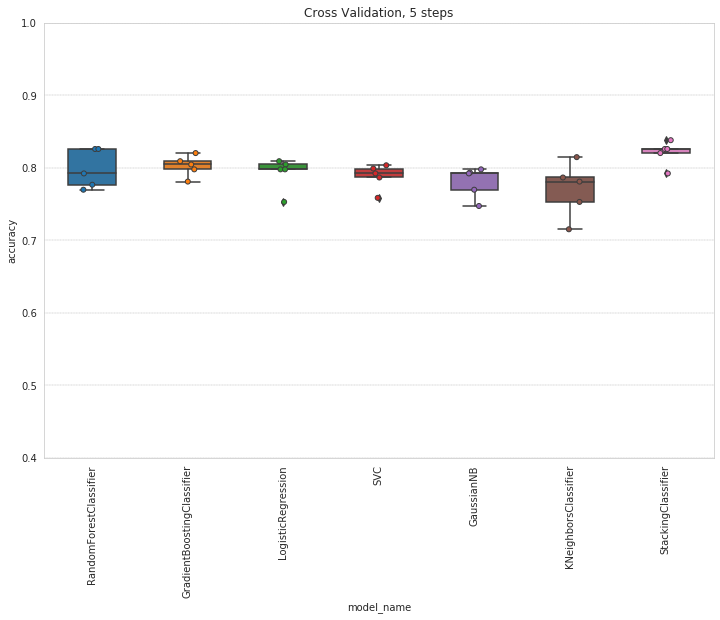

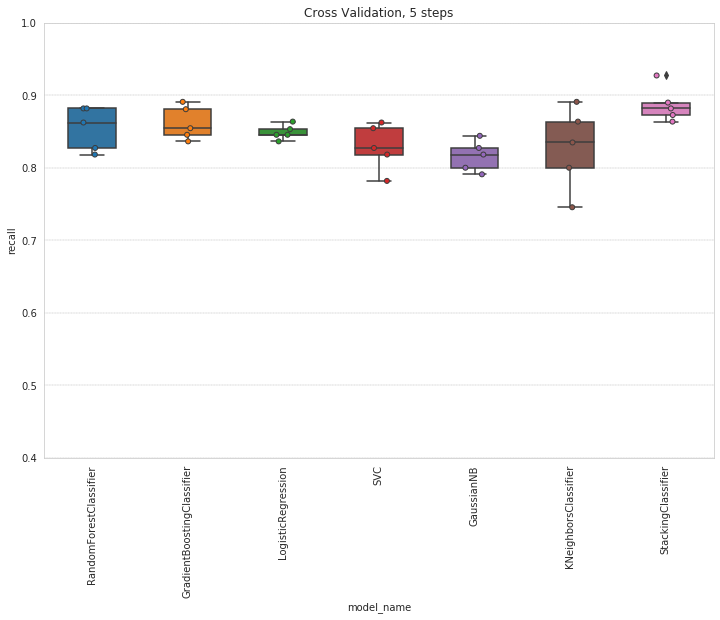

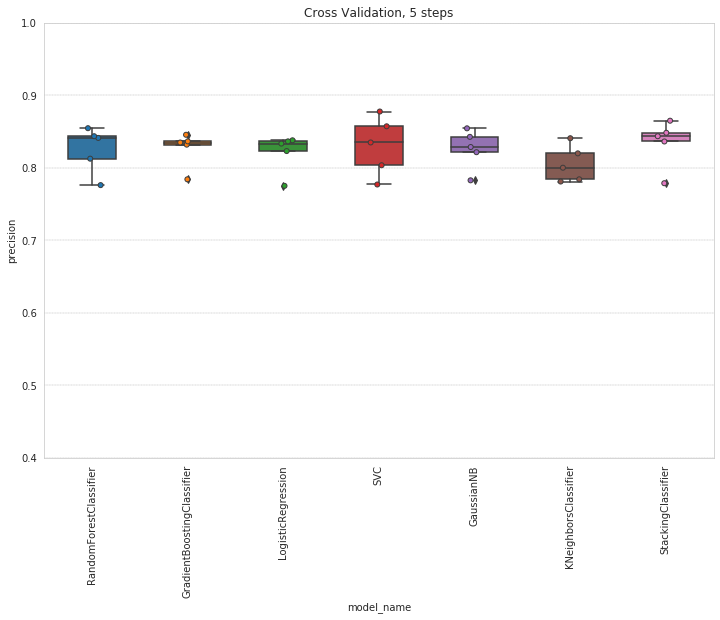

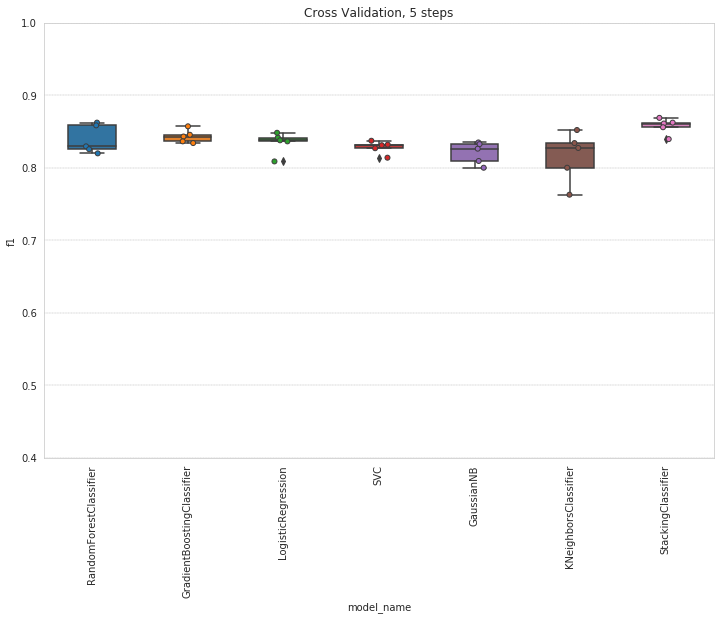

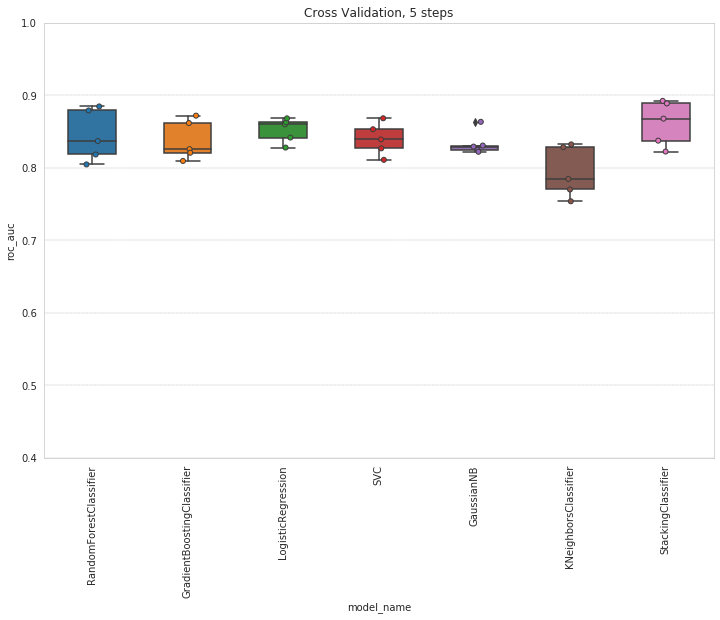

In [117]:
k=5
for scrr in ['accuracy','recall', 'precision', 'f1', 'roc_auc']:
    print(f'Currently fitting {scrr}:')
    cv_df = cv_check(X=data_to_train.drop(columns=['Survived', 'died'],axis=1),
                     y=data_to_train.died,
                     CV=k,
                     scorer=scrr, 
                     models=models.values())
    #cv_df.groupby(['model_name']).mean().drop(columns=['fold_idx'])
    cv_bp(cv_df, f'Cross Validation, {k} steps', scrr)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(data_to_train.drop(columns=['Survived', 'died']), 
                                                    data_to_train.died,  
                                                    test_size=0.25, 
                                                    stratify=data_to_train.died)

In [119]:
scorers_list

['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

In [93]:
# s='roc_auc'
# for label, model in zip(models.keys(), models.values()):
#     scores = cross_val_score(model, 
#                              X=train_data.drop(columns=['Survived', 'died']),
#                              y=train_data.died,
#                              scoring=s,
#                              cv=5)
#     print(f'{s}: {scores.mean()}, (+/- {scores.std()}), {label}')

In [138]:
def df_of_pred(models, X_train, X_test, y_train):
    df = pd.DataFrame(index=X_test.index)
    proba = pd.DataFrame(index=X_test.index)
    for model in models.keys():
        model_name = model.__class__.__name__
        trained = models[model].fit(X_train, y_train)
        df[model] = trained.predict(X_test)
        proba[model] = trained.predict_proba(X_test)[:,1]
    return df, proba

In [139]:
predictions, probas = df_of_pred(models, X_train, X_test, y_train)
# predictions = df_of_pred(models, X_train, X_test, y_train)
predictions.head()
# probas.head()

RandomForest  GradientBoosting  LogisticRegression  SVC  \
PassengerId                                                            
361                     1                 1                   1    1   
286                     1                 1                   1    1   
249                     1                 1                   1    1   
877                     1                 1                   1    1   
727                     0                 0                   0    0   

             GaussianNB  KNN  Stacking  
PassengerId                             
361                   1    1         1  
286                   1    1         1  
249                   1    1         1  
877                   1    1         1  
727                   0    0         0

In [140]:
# f = plt.figure(figsize=(10,5))
# h = np.sum(predictions.drop(columns=['DummyClassifier']), axis=1)
# h_value_counts = h.value_counts(sort=False, normalize=True)
# bars=sns.barplot(h_value_counts.index, y=h_value_counts.values)
# title=plt.title('percentage of the persons the models agreed on their predictions')
# xlabel=plt.xlabel('sum of predictions')
# ylabel=plt.ylabel('percentage')
# grid=plt.grid(axis='y', ls=':')

In [141]:
def voting(df_of_pred):
#     df_of_pred['vote_count']=np.sum(df_of_pred, axis=1)
#     df_of_pred['verdict']=df_of_pred['vote_count'].map(lambda x: 1 if x>=5 else 0)
    for i in df_of_pred.index:
        if np.sum(df_of_pred.loc[i]) >= 4:
            df_of_pred.loc[i, 'verdict'] = 1
            
        elif np.sum(df_of_pred.loc[i]) <= 2:
            df_of_pred.loc[i, 'verdict'] = 0  
            
        else:
            df_of_pred.loc[i, 'verdict'] = 1 if np.random.random()>=0.65 else 0
            
    return df_of_pred

def vote_median(probas, d_bound):
    probas['vote_proba_mean']=np.median(probas, axis=1)
    probas['verdict'] = probas['vote_proba_mean'].map(lambda x: 0 if x<=d_bound else 1)
    return probas

In [142]:
# # predictions.drop(columns=['DummyClassifier'], inplace=True)
# pred = voting(predictions.drop(columns=['DummyClassifier'])).verdict if 'DummyClassifier' in predictions.columns \
#         else voting(predictions).verdict
pred = predictions.Stacking
# probs = vote_median(probas, np.sum(train_data.died)/len(train_data)).vote_proba_mean
# pred = predictions.RandomForestClassifier
# probs = probas.RandomForestClassifier
# probs.head()

array([[ 63,  23],
       [ 19, 118]])

(0, 2)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        86
           1       0.84      0.86      0.85       137

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



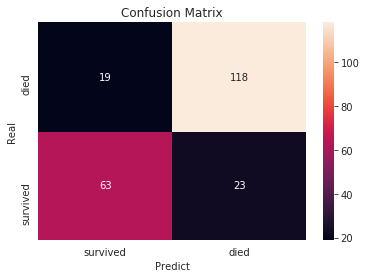

In [143]:
# prints confusion matrix heatmap    
cm = confusion_matrix(y_test, pred)
cm
a = sns.heatmap(cm, annot=True, fmt='.3g', 
            xticklabels=['survived', 'died'], 
            yticklabels=['survived', 'died']).set_title('Confusion Matrix')
x = plt.ylabel('Real')
y = plt.xlabel('Predict')
plt.ylim(0,2)

#output classification report to prompt and to csv file
print(classification_report(y_test, pred))

Text(0.5, 1.0, 'ROC curve (area = 0.80)')

[Text(0, 0.5, 'True Positive Rate'), Text(0.5, 0, 'False Positive Rate')]

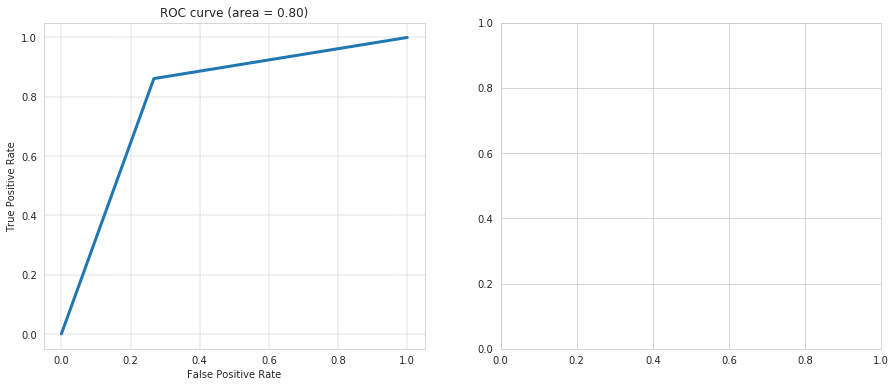

In [144]:
f, axes = plt.subplots(1,2, figsize=(15,6))
#roc curve and auc data in the title
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred)
roc_auc = auc(fpr,tpr)
axes[0].plot(fpr, tpr, lw=3)
axes[0].set_title('ROC curve (area = {:0.2f})'.format(roc_auc))
axes[0].set(xlabel='False Positive Rate',ylabel='True Positive Rate')
axes[0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

# #plot precision-recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs)
# best_index = np.argmin(np.abs(precision-recall))   # set the best index to be the minimum delta between precision and recall
# axes[1].plot(precision,recall)
# axes[1].set_title('Precision-Recall Curve')
# axes[1].set(xlabel='Precision', ylabel='Recall', xlim=(0,1.05))
# axes[1].plot(precision[best_index],recall[best_index],'o',color='r')
# axes[1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

In [146]:
# n=1000
# models = [
#         RandomForestClassifier(criterion='gini', max_features='auto', n_estimators=n, random_state=42, n_jobs=4),
#         GradientBoostingClassifier(loss='deviance', n_estimators=n, random_state=42),
#         AdaBoostClassifier(n_estimators=n, random_state=42),
#         LogisticRegression(penalty='l1',
#                            solver='liblinear',
#                            multi_class='ovr',
#                            max_iter=1000,
#                            C=1,
#                            random_state=42,
#                            class_weight='balanced'),
#         SVC(C=1, kernel='rbf', gamma='auto', random_state=42, class_weight='balanced', probability=True),
#         KNeighborsClassifier(n_neighbors=17, n_jobs=jobs),
#         GaussianNB()
# ]
models_pred, models_probas = df_of_pred(models, 
                                        X_train=data_to_train.drop(columns=['Survived','died']), 
                                        X_test=data_to_test,
                                        y_train=data_to_train.died)
models_pred.head()
models_probas.head()

RandomForest  GradientBoosting  LogisticRegression  SVC  \
PassengerId                                                            
892                     1                 1                   1    1   
893                     0                 0                   0    0   
894                     1                 1                   1    1   
895                     1                 1                   1    1   
896                     1                 0                   0    0   

             GaussianNB  KNN  Stacking  
PassengerId                             
892                   1    1         1  
893                   0    1         0  
894                   1    1         1  
895                   1    1         1  
896                   0    0         0

RandomForest  GradientBoosting  LogisticRegression       SVC  \
PassengerId                                                                 
892              0.764444          0.896602            0.900496  0.830328   
893              0.468889          0.021183            0.440603  0.270226   
894              0.607392          0.895784            0.753693  0.830102   
895              1.000000          0.911028            0.900496  0.830327   
896              0.588889          0.396656            0.366685  0.270564   

             GaussianNB       KNN  Stacking  
PassengerId                                  
892            0.999780  0.981752  0.874703  
893            0.001171  0.928549  0.320585  
894            0.997443  0.598972  0.786670  
895            0.999781  1.000000  0.914477  
896            0.000029  0.350080  0.398184

In [147]:
models_pred = voting(models_pred.drop(columns=['DummyClassifier'])) if 'DummyClassifier' in models_pred.columns \
        else voting(models_pred)
models_pred.head()

RandomForest  GradientBoosting  LogisticRegression  SVC  \
PassengerId                                                            
892                     1                 1                   1    1   
893                     0                 0                   0    0   
894                     1                 1                   1    1   
895                     1                 1                   1    1   
896                     1                 0                   0    0   

             GaussianNB  KNN  Stacking  verdict  
PassengerId                                      
892                   1    1         1      1.0  
893                   0    1         0      0.0  
894                   1    1         1      1.0  
895                   1    1         1      1.0  
896                   0    0         0      0.0

In [148]:
models_probas = vote_median(models_probas.drop(columns=['DummyClassifier']) if 'DummyClassifier' in models_probas.columns \
        else models_probas, np.sum(train_data.died)/len(train_data))
models_probas.head()

RandomForest  GradientBoosting  LogisticRegression       SVC  \
PassengerId                                                                 
892              0.764444          0.896602            0.900496  0.830328   
893              0.468889          0.021183            0.440603  0.270226   
894              0.607392          0.895784            0.753693  0.830102   
895              1.000000          0.911028            0.900496  0.830327   
896              0.588889          0.396656            0.366685  0.270564   

             GaussianNB       KNN  Stacking  vote_proba_mean  verdict  
PassengerId                                                            
892            0.999780  0.981752  0.874703         0.896602        1  
893            0.001171  0.928549  0.320585         0.320585        0  
894            0.997443  0.598972  0.786670         0.786670        1  
895            0.999781  1.000000  0.914477         0.914477        1  
896            0.000029  0.350080  0.398184         0.366685        0

In [149]:
final = pd.DataFrame({'Survived': 1-models_pred.verdict.astype('int64')})
final.head(20)

Survived
PassengerId          
892                 0
893                 1
894                 0
895                 0
896                 1
897                 0
898                 1
899                 0
900                 1
901                 0
902                 0
903                 0
904                 1
905                 0
906                 1
907                 1
908                 0
909                 0
910                 0
911                 1

In [150]:
final.to_csv('predictions {}.csv'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))